## Vehicle Detection and Tracking
### Udacity Self-Driving Car Nanodegree. Project 5

In [9]:
%reload_ext autoreload
%autoreload 2
from vehicle import *
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In order to make self-driving car safe and reliable, we need to know what's happening around the car.  
Obstacles detection in general and vehicle detection in particular is a crucial step towards autonomous driving.  

### Dataset and classifier
Vehicle detection is a classification task and I'm going to train my Linear SVM classifier on the provided datasets.

The attempts to use dataset as it is caused significant overfitting. The reason for this is a time series nature of the data: images where croped from the video and have 5-10 almost similar pictures. If I use train-test-split approach, similar images appear in the training and testing datasets. To avoid this situation, I'm taking each 5th image from the dataset. That makes my model robust to overfitting.  
  
Function classifier initialize Linear SVM classifier and reports the accuracy 0.9831 on a testing dataset. I've tested the classifier additionally on the unseen noncar and car data and get the following results:  
*  accuracy of predicting unseen cars is 0.8712
*  accuracy of predicting unseen noncars is 0.9982
which promises to have low amount of false positives.
The accuracy of the dataset is not excelent (and true positive detection might be better) and I was wondering if another algorithm might be better for the project. F.ex. ensemble algorithms usually shows much better performance. 
However, I've decided to stay with Linear SVM because of good training and prediction speed. Ensemble method still remains slow, especially for online image processing. On Feb 27, 2017 IBM Research published the paper [1], promising algorithm with a great performance of ensemble algorithms but much higher speed. I'm excited to try it in the near future.

The provided datasets contains RGB images with the shape 64x64 containing cars and non-cars.

In [3]:
cars, noncars = load_data(size='big',portion=1)

Loading data
There are 8792 cars images and 8968 noncars images
Test image in the big dataset has shape (64, 64, 3), type uint8
Test image intensity encoded by values from 33 to 192
Shape of cars array is (8792, 64, 64, 3), noncars is (8968, 64, 64, 3)
Loaded 8792 cars
Loaded 8968 noncars


### Features
To make the classifier efficient, I should extract important features from the images. 
I've chosen to use Histogram of Oriented Gradients (HOG) feature on a YCrCb image representation.  
  
Class Features (lines 392 - 407) defined to easily and uniformly manage features across classifier and video processing.
  
The function extract_features (lines 63 - 91) extracts features from the images in the training dataset, function extract_feature (lines 169 - 202) extract HOG features from the each image. I'm using the same funcion during video processing to extract features from the sliding windows.

The function get_dataset (lines 93 - 126) takes the cars and non-cars features and create train and test datasets, which I then use to train my classifier.  

When feature vector is prepared, I'm using scaler function from sklearn to normalize it by columns.

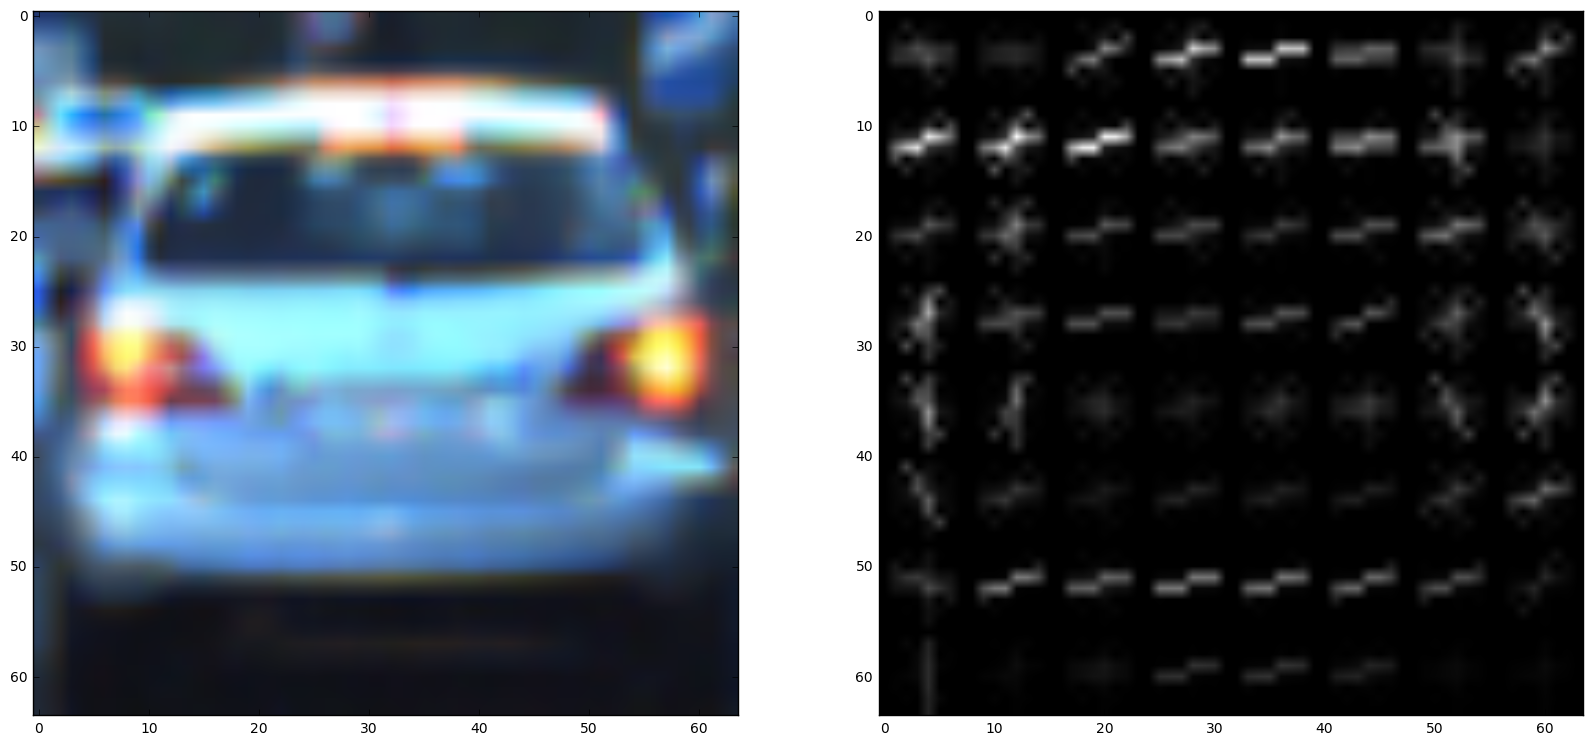

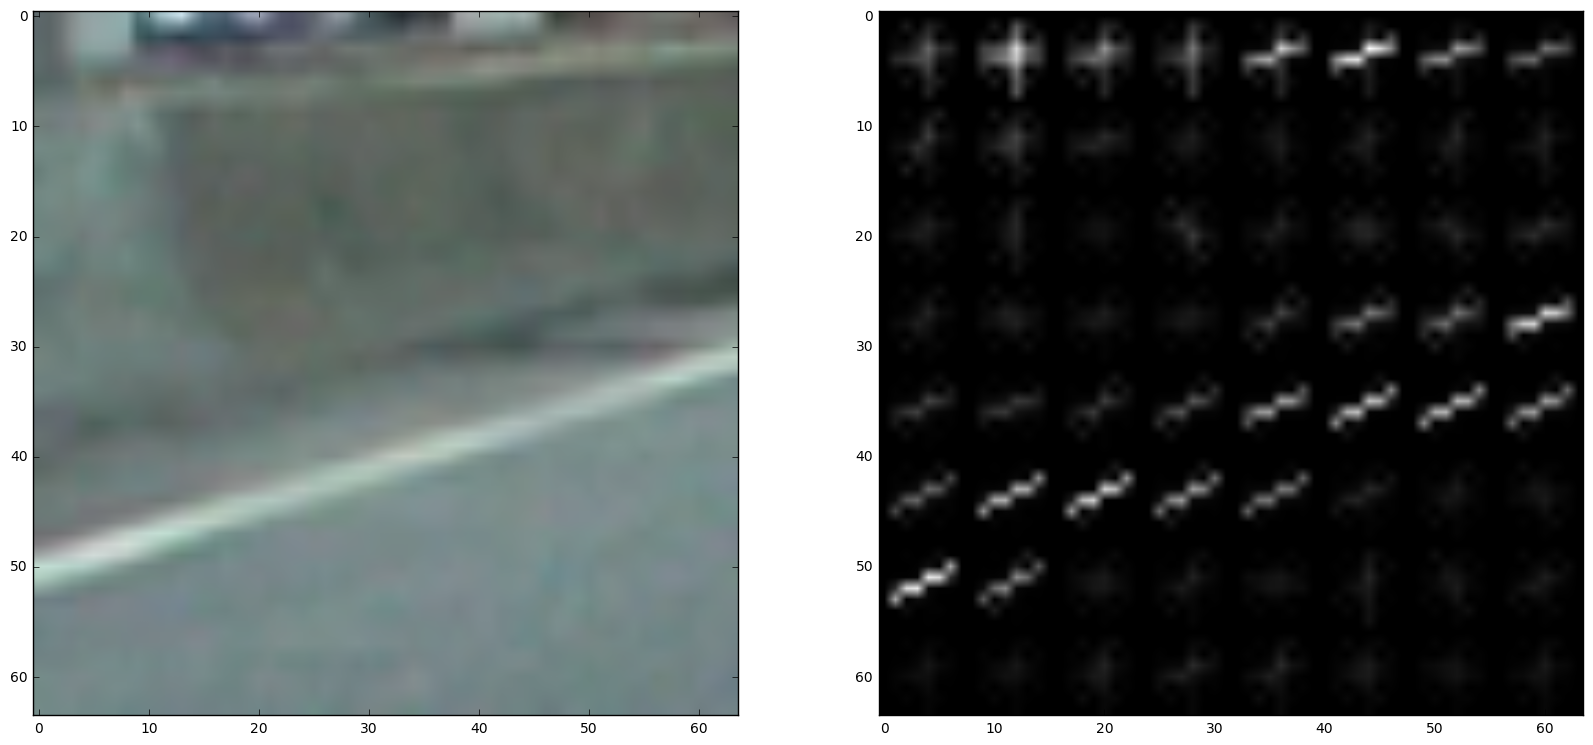

In [41]:
ind = 6000
feat,hog_car = get_hog_features(cars[ind][:,:,0], 9, 8, 2, vis=True)
show_2gr(cars[ind], hog_car)
feat,hog_noncar = get_hog_features(noncars[ind][:,:,0], 9, 8, 2, vis=True)
show_2gr(noncars[ind], hog_noncar)

In [27]:
fs1 = Features(cspace='YCrCb',orient=9, pix_per_cell=8, cell_per_block=2, 
               hog_channel='ALL', hist_feat=False, spatial_feat=False)
# extract car/noncar features 
cars_feat, noncars_feat = extract_features(cars, noncars, fs1, portion = 5, feature_vec=True)
# create dataset
X_train, X_test, y_train, y_test = get_dataset(cars_feat, noncars_feat, fs1, approach='tetrsp')
clf1 = classifier(X_train, X_test, y_train, y_test)

Extracting features from each 5 images in the dataset
Feature vector of test image for channel(s) ALL, hist_feat False, spatial_feat False has shape (5292,)
Shape of cars features array is (1759, 5292), noncars features is (1794, 5292)
Loaded 1759 cars feature vectors
Loaded 1794 noncars feature vectors
Features vector created with the shape (3553, 5292)
Labels vector created with the shape (3553,)
Dataset is split into train and test datasets
X_train shape (2842, 5292), X_test shape (711, 5292)
Training Linear SVM Classifier
0.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9831


### Sliding windows
When my classifier is trained, I can set up the pipeline to process the video and detect vehicles on it.
I've defined function get_positive_boxes (lines 217 - 282) to implement sliding window to detect vehicles on the image of the video:
1.  Keeping in mind perspective and vanishing point concepts, I've detected manually vanishing point on the image.
2.  I'm implementing sliding window so, that windows are big in front of the car and getting smaller as we're moving f rom the car towards vanishing point. This let me keep the number of sliding windows relatively small.  
3.  As the training images are 64 x 64 px, the smalles window has the size of 64 x 64 px. Other windows sizes are 96, 128, 160, 192, 224, 256, 288; overlapping is 2 blocks (75%) - parameters were chosen imperically. All windows, bigger than 64, are resized to 64 x 64 px.

In [28]:
cars_obj = Cars(clf1, fs1)

### Vehicle Detection and Tracking pipeline
Function get_positive_windows returns all sliding windows, which were predicted as positives. These boxes often overlaps each other, sometimes I got false positives boxes as well. In order to improve the robustness of the model, I've worked on the following:
*  tested different color shemes for features vectors and found out that YCrCb gives best performance with 2 cells per block (YUV follows);
*  tried different datasets for classifier training and finished using each 5th image with test_train_split function from sklearn libray (80:20).
*  I've used a heatmap of the positive boxes with the bottom threshold of 2 boxes. Then I've got labels from the heatmap  and applied labels threshold (calculating the hottest point for the label and if it was bellow the threshold of 2, I've removed the entire label box. 

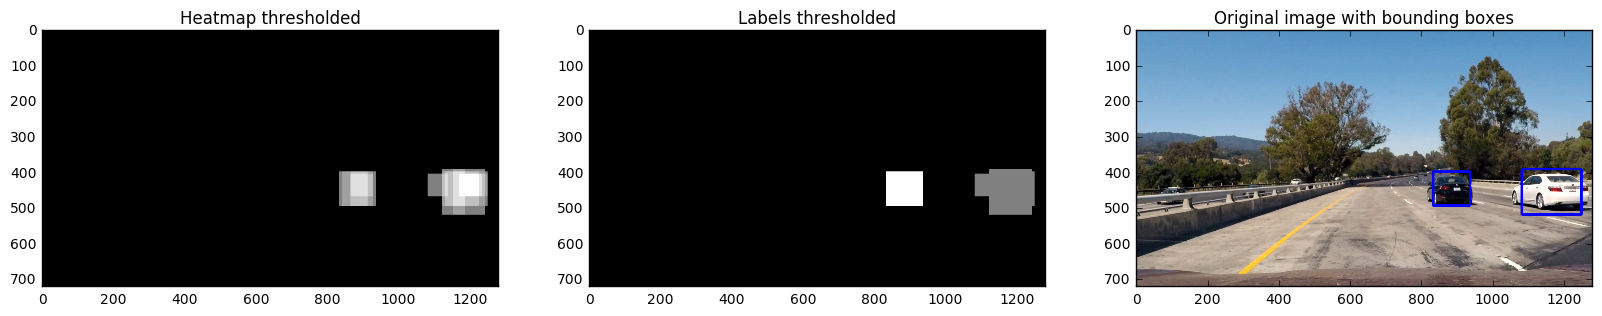

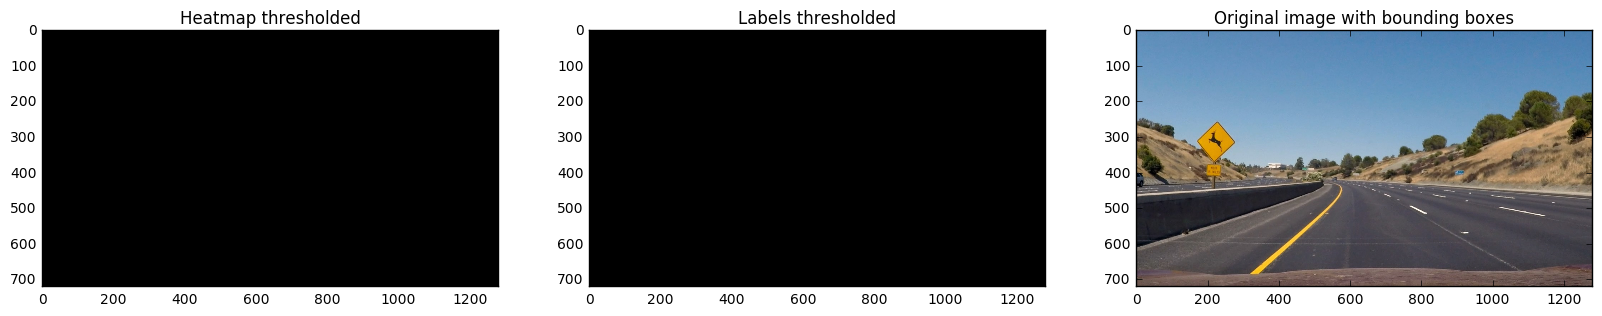

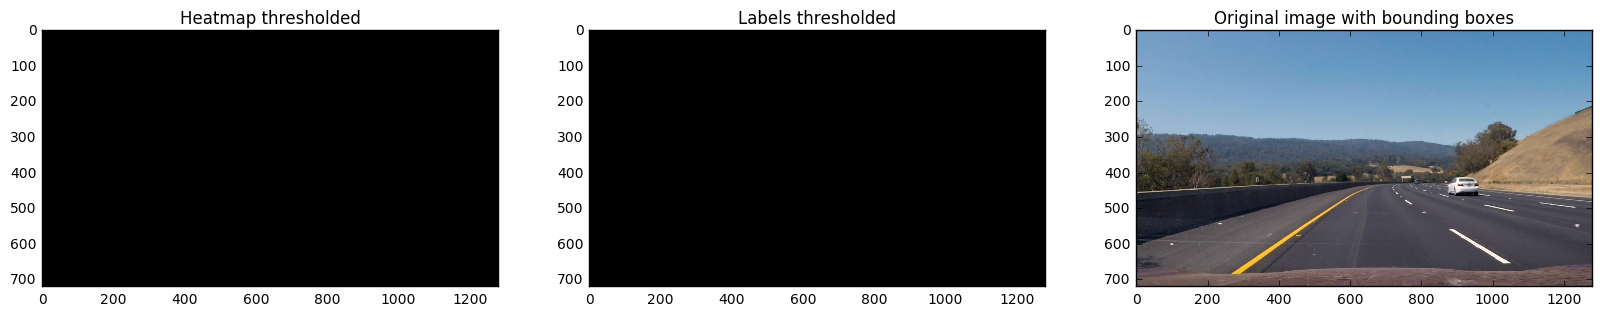

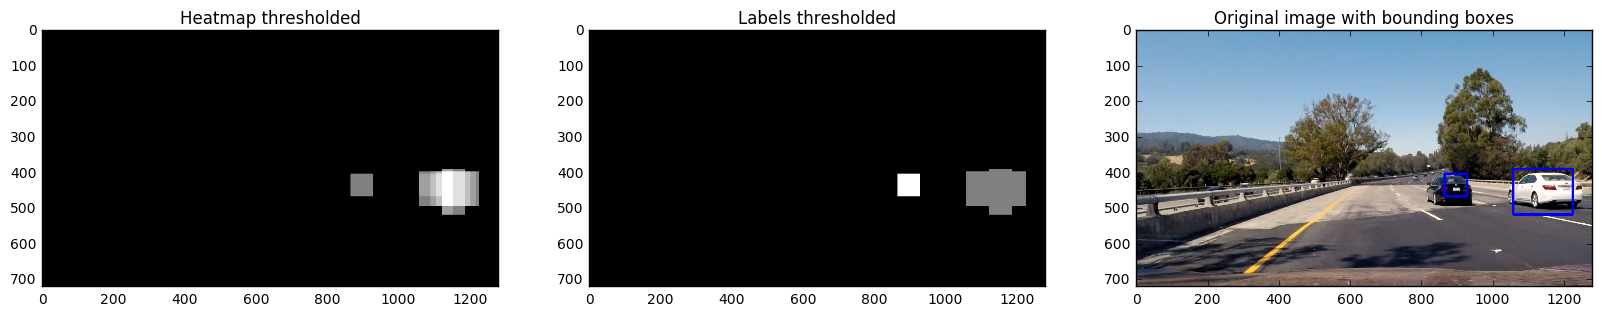

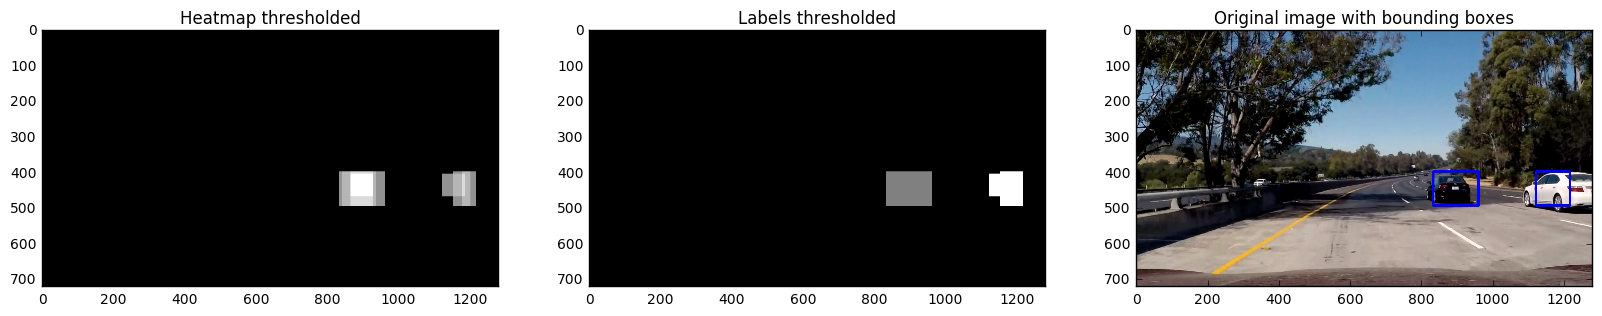

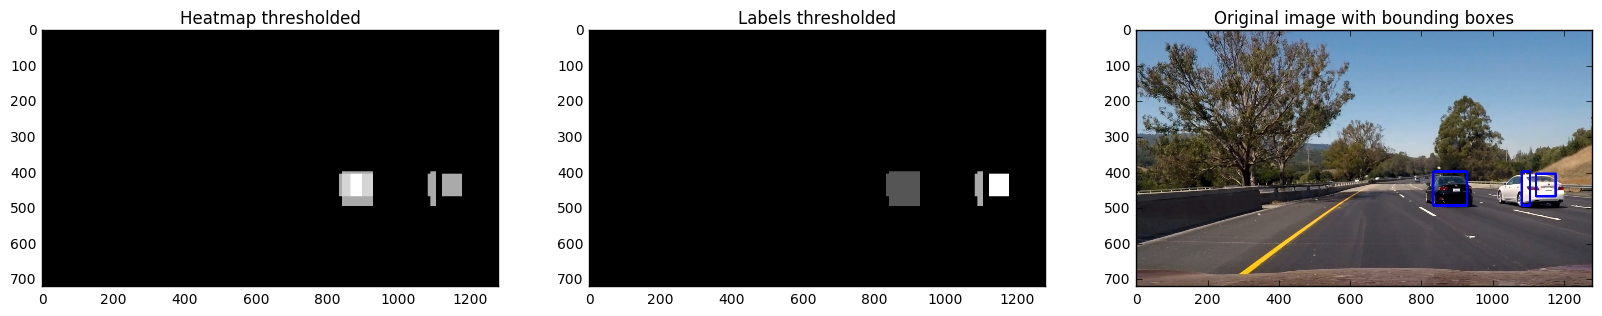

In [35]:
url_test = '../CarND-Vehicle-Detection/test_images/*.jpg'
urls = glob.glob(url_test)
for url in urls:
    test_img = cv2.imread(url)[:,:,::-1]
    result = cars_obj.pipeline(test_img)
    f,ax = plt.subplots(1,3, figsize=(20,10))
    ax[0].imshow(cars_obj.heatmap, cmap='gray')
    ax[0].set_title('Heatmap thresholded')
    ax[1].imshow(cars_obj.labels[0], cmap='gray')
    ax[1].set_title('Labels thresholded')
    ax[2].imshow(result)
    ax[2].set_title('Original image with bounding boxes')

### Video processing and additional filters
Given a fact that video is a sequence of images where objects change slowly, we could use additional filters of the vehicle detections.

The video file was processed and loaded to GitHub. It's available here: https://github.com/olegleyz/SDCND-p5-vehicle-detection/blob/master/video.mp4

### Outcomes
I was excited to work on this project, especially on getting such important features from images as HOG.  
The robustness of the model should be improved: currently bounding boxes are not smoothing (although the similar to sliding window technique of boxes with the size decreasing toward vanishing point with the center in the centroid might be applied).
More sofisticated approaches of filtering false positives in a video stream are going to be applied in the next version of this project. 
Last but not least, time of the video processing is still far away from the real time. The optimization work is one of the key tasks for future.

### Reference
1. Fast and Accurate Inference with Adaptive Ensemble Prediction in Image Classification with Deep Neural Networks. https://arxiv.org/abs/1702.08259